# Some image retrieval experiments, calculating mean reciprocal rank

In [1]:
import sys
import os
sys.path.append("../")
os.chdir('../')

In [2]:
from os import listdir
from os.path import isfile, join
import time
import json
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import skimage.transform
import tensorflow as tf
from models import refgoog_attention_model

import util.io
from models.spatial_feat import spatial_feature_from_bbox
from util.refgoog_baseline_train.roi_data_reader import DataReader
from util import text_processing, im_processing
from models import refgoog_attention_model

%matplotlib inline

In [3]:
imdb_file = './dwright-exp-image-ranking/imdb_retrieval.json'
vocab_file = './word_embedding/vocabulary_72700.txt'
im_mean = refgoog_attention_model.fastrcnn_vgg_net.channel_mean
T=20
min_size=600
max_size=1000

vocab_dict = text_processing.load_vocab_dict_from_file(vocab_file)

In [4]:
roidb = util.io.load_json(imdb_file)

In [5]:
len(roidb)

20

In [6]:
#Preprocess the corpus
images = {}
refexps = {}
for iminfo in roidb:
    im_dict = {}
    im_path = iminfo['im_path']
    im = skimage.io.imread(im_path)
    if im.ndim == 2:
        im = np.tile(im[..., np.newaxis], (1, 1, 3)) 

    # calculate the resize scaling factor
    im_h, im_w = im.shape[:2]
    # make the short size equal to min_size but also the long size no bigger than max_size
    scale = min(max(min_size/im_h, min_size/im_w), max_size/im_h, max_size/im_w)

    # resize and process the image
    new_h, new_w = int(scale*im_h), int(scale*im_w)
    im_resized = skimage.img_as_float(skimage.transform.resize(im, [new_h, new_w]))
    im_processed = im_resized*255 - im_mean
    im_dict['image'] = im_processed[np.newaxis, ...].astype(np.float32)
    
    # annotate regions
    regions = iminfo['regions']
    if len(regions) == 0:
        raise IOError('no region annotations for image ' + im_path)
    region_bboxes = np.array([ann[0] for ann in regions], np.float32)
    # save coco_bboxes, needed for evaluation code
    coco_bboxes = region_bboxes.copy()
    # back to [x, y, w, h]
    coco_bboxes[:, 2:4] = coco_bboxes[:, 2:4] - coco_bboxes[:, 0:2] + 1 
    region_bboxes *= scale
    region_bboxes = im_processing.rectify_bboxes(region_bboxes, height=new_h, width=new_w)

    # For each ROI R = [batch_index x1 y1 x2 y2]: max pool over R
    bbox_batch = np.zeros((len(region_bboxes), 5), np.float32)
    bbox_batch[:, 1:5] = region_bboxes
    spatial_batch = spatial_feature_from_bbox(region_bboxes, im_h=new_h, im_w=new_w)
    
    im_dict['bbox'] = bbox_batch
    im_dict['spatial_box'] = spatial_batch
    images[im_path] = im_dict
    
    # a region may have zero, one or more sentence annotations
    # align language sequences with regions
    text_seq_batch = []
    label_batch = []
    coco_ann_ids = []  # needed for evaluation code
    questions = []  # needed for evaluation code
    for n in range(len(regions)):
        for n_s in range(len(regions[n][1])):
            s = regions[n][1][n_s]
            refexps[s] = {'text_seq': np.asarray(text_processing.preprocess_sentence(s, vocab_dict, T)).reshape((T,1)),
                          'im_path': im_path,
                          'ground_truth': regions[n][0] }
            

/home/dwright/python_envs/p3MachineLearning/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [7]:
regions[1]

[[312.69, 43.2, 467.59000000000003, 415.3],
 ['A girl in a white tshirt holds a wii controller.',
  'A woman with a tattoo, in white shirt  holding a video game controller'],
 421708]

## Build the model

In [8]:
snapshot_file = './downloaded_models/refgoog_attbilstm_iter_150000.tfmodel'
num_vocab = 72704
embed_dim = 300 
lstm_dim = 1000

################################################################################
# The model
################################################################################

# Inputs
text_seq_batch = tf.placeholder(tf.int32, [T, None])
im_batch = tf.placeholder(tf.float32, [1, None, None, 3]) 
bbox_batch = tf.placeholder(tf.float32, [None, 5]) 
spatial_batch = tf.placeholder(tf.float32, [None, 5]) 

# Outputs
scores, probs_obj1, probs_obj2, probs_rel = refgoog_attention_model.refgoog_attbilstm_net(im_batch, bbox_batch,
    spatial_batch, text_seq_batch, num_vocab, embed_dim, lstm_dim,
    vgg_dropout=False, lstm_dropout=False)

In [9]:
# Start Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)))

# Snapshot saver
snapshot_saver = tf.train.Saver()
snapshot_saver.restore(sess, snapshot_file)

INFO:tensorflow:Restoring parameters from ./downloaded_models/refgoog_attbilstm_iter_150000.tfmodel


In [11]:
ref_scores = {ref: {'scores': []} for ref,_ in refexps.items()}
times_slow = []

for ref,ref_batch in refexps.items():
    start = time.time() 
    #Test all the images for this expression
    for im_path,im_features in images.items():
        text_seq_val  = ref_batch['text_seq']
        im_val        = im_features['image']
        bbox_val      = im_features['bbox']
        spatial_val   = im_features['spatial_box']
        
        # Forward and Backward pass
        scores_val, obj1_prob, obj2_prob, rel_prob = sess.run([scores, probs_obj1, probs_obj2, probs_rel],
            feed_dict={
                text_seq_batch  : text_seq_val,
                im_batch        : im_val,
                bbox_batch      : bbox_val,
                spatial_batch   : spatial_val
            })
        predicts = np.argmax(scores_val, axis=1)
        out_dict = {'im_path': im_path, 'score': np.max(scores_val, axis=1)[0]}
        if im_path == ref_batch['im_path']:
            out_dict['ground_truth'] = ref_batch['ground_truth']
            
        ref_scores[ref]['scores'].append(out_dict)
    end = time.time()
    times_slow.append(end-start)
    
    ref_scores[ref]['attention'] = {'sub': obj1_prob.reshape(T), 'rel': rel_prob.reshape(T), 'obj': obj2_prob.reshape(T)}

In [12]:
print(sum(times_slow) / len(times_slow))
print(sum(times_slow))

63.150978344678876
2526.039133787155


## Build the fast model

In [7]:
snapshot_file = './downloaded_models/refgoog_attbilstm_iter_150000_no_vgg.tfmodel'
num_vocab = 72704
embed_dim = 300 
lstm_dim = 1000

################################################################################
# The model
################################################################################

# Inputs
text_seq_batch = tf.placeholder(tf.int32, [T, None])
vis_feat = tf.placeholder(tf.float32, [None, 4096])
spatial_batch = tf.placeholder(tf.float32, [None, 5]) 

# Outputs
scores = refgoog_attention_model.refgoog_retrieval_baseline(vis_feat,
    spatial_batch, text_seq_batch, num_vocab, embed_dim, lstm_dim)

In [8]:
# Start Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)))

# Snapshot saver
snapshot_saver = tf.train.Saver()
snapshot_saver.restore(sess, snapshot_file)

INFO:tensorflow:Restoring parameters from ./downloaded_models/refgoog_attbilstm_iter_150000_no_vgg.tfmodel


In [9]:
def scoreImgOnQuery(text_seq_val, vfeat, sfeat):
   # Forward and Backward pass
    scores_val = sess.run([scores],
        feed_dict={
            text_seq_batch  : text_seq_val,
            vis_feat        : vfeat,
            spatial_batch   : sfeat
        })

    return np.max(scores_val[0], axis=1)[0] 

### Ranking within the small example set

In [17]:
ref_scores_previs = {ref: {'scores': []} for ref,_ in refexps.items()}
times = []
for ref,ref_batch in refexps.items():  
    start = time.time()
    #Test all the images for this expression
    for im_path,im_features in images.items():
        text_seq_val  = ref_batch['text_seq']
        #Read the visual features
        name = os.path.basename(im_path)
        name = name[:name.rfind('.')]
        visfile = '/hdd/dustin/data/gref_val_roifwdprop/' + name + '.npy'
        with open(visfile, 'rb') as f:
            vfeats = np.load(f)
        
            img_score = scoreImgOnQuery(text_seq_val, vfeats['vis_feat'], vfeats['spatial_feature'])
            
        out_dict = {'im_path': im_path, 'score': img_score}
        if im_path == ref_batch['im_path']:
            out_dict['ground_truth'] = ref_batch['ground_truth']
            
        ref_scores_previs[ref]['scores'].append(out_dict)
    end = time.time()
    times.append(end-start)
    
    #ref_scores_previs[ref]['attention'] = {'sub': obj1_prob.reshape(T), 'rel': rel_prob.reshape(T), 'obj': obj2_prob.reshape(T)}

In [19]:
print(sum(times) / len(times))
print(sum(times))

2.200582301616669
88.02329206466675


### Compute MRR with 1000 random train samples

In [10]:
import bisect

imdb_file = './exp-refgoog/data/imdb/imdb_val.npy'
image_dir = '/hdd/dustin/data/gref_train_1000_roifwdprop/'
reader = DataReader(imdb_file, vocab_file, im_mean, shuffle=True)

img_files = [join(image_dir, f) for f in listdir(image_dir) if isfile(join(image_dir, f)) and f[-4:] in '.npz']

vis_feats = []
spatial_feats = []

for im in img_files:
    with open(im, 'rb') as f:
        v = np.load(f)
        vis_feats.append(v['vis_feat'])
        spatial_feats.append(v['spatial_feature'])

mrr = []
for n in range(reader.num_batch):
    batch = reader.read_batch()
    #Get batch image activations
    name = os.path.basename(batch['im_path'])
    name = name[:name.rfind('.')]
    visfile = '/hdd/dustin/data/gref_val_roifwdprop/' + name + '.npz'
    with open(visfile, 'rb') as f:
        vcurr = np.load(f)
        vis_curr = vcurr['vis_feat']
        spatial_curr = vcurr['spatial_feature']
    
    ranks = []
    for text_seq_val in batch['text_seq_batch'].T:
        text_seq_val = text_seq_val[:, np.newaxis]
        curr_ranks = []
        for v,s in zip(vis_feats, spatial_feats):
            img_score = scoreImgOnQuery(text_seq_val, v, s)
            bisect.insort(curr_ranks, -img_score)
        
        #Get the ground truth rank
        gt_score = scoreImgOnQuery(text_seq_val, vis_curr, spatial_curr)
        
        #Get the rank
        rank = bisect.bisect(curr_ranks, -gt_score)
        print(rank)
        mrr.append(1./(rank + 1)

Loading ROI data from file...Done.


/home/dwright/python_envs/p3MachineLearning/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


data reader: epoch = 0, batch = 0 / 4650
52
110
data reader: epoch = 0, batch = 1 / 4650
171
259
data reader: epoch = 0, batch = 2 / 4650
143
179
data reader: epoch = 0, batch = 3 / 4650
76
data reader: epoch = 0, batch = 4 / 4650
5
0


ZeroDivisionError: float division by zero

In [12]:
def draw_bbox(ax, bbox, edge_color='red', line_width=3):
    """Draw one bounding box on a matplotlib axis object (ax)."""
    import matplotlib.patches as mpatches
    
    bbox_plot = mpatches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
        fill=False, edgecolor=edge_color, linewidth=line_width)
    ax.add_patch(bbox_plot)

In [18]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(1, 1, 1), (1, 0, 0)]
cm = LinearSegmentedColormap.from_list(
        'text_cmap', colors)
def makeHeatmap(attention, words, ax, title=""):
    plt.figure(figsize=(18, 1.5))
    heatmap = plt.pcolor(attention, cmap=cm)
    i = 0
    for x in range(len(attention[0])):
        plt.text(x + 0.5, 0.5, words[i], horizontalalignment='center', verticalalignment='center')
        i += 1
        
    plt.gca().get_xaxis().set_visible(False)
    plt.title(title)

In [20]:
from matplotlib.backends.backend_pdf import PdfPages

def multipage(filename, figs=None, dpi=200):
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()

In [13]:
import re

SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
def split(sentence):
    if isinstance(sentence, bytes):
        sentence = sentence.decode()
    words = SENTENCE_SPLIT_REGEX.split(sentence.strip())
    words = [w.lower() for w in words if len(w.strip()) > 0]
    # remove .
    if len(words) > 0 and (words[-1] == '.' or words[-1] == '?'):
        words = words[:-1]
        
    if len(words) > 20:
        words = words[:20]
    return words

In [21]:
def plotRefScores(ref_scores)
    import operator
    fig_dir = '/hdd/dustin/data/hu_et_al_eval/image_retrieval_baseline_20imgs'

    i = 0
    mrr = []
    for ref,scores in ref_scores.items():
        sorted_scores = sorted(scores['scores'], key=lambda k: k['score'], reverse=True)
        out_dir = fig_dir + '/' + str(i)
        if not os.path.exists(out_dir):
            os.mkdir(out_dir)

        for s in range(len(sorted_scores)):
            img = skimage.io.imread(sorted_scores[s]['im_path'])
            plt.figure(figsize=(18,18))
            plt.imshow(img)

            if 'ground_truth' in sorted_scores[s]:
                draw_bbox(plt.gca(), sorted_scores[s]['ground_truth'], edge_color='green')
                plt.title("CORRECT IMAGE -- " + ref + ': rank ' + str(s))
                mrr.append(1. / (s + 1))

            else:
                plt.title(ref + ': rank ' + str(s))
            plt.savefig(out_dir + "/%3d.pdf" % s)
            plt.close('all')

        ref = split(ref)
        sub = scores['attention']['sub'][-len(ref):]
        makeHeatmap([sub], ref, plt.gca(), title='Subject attn')
        rel = scores['attention']['rel'][-len(ref):]
        makeHeatmap([rel], ref, plt.gca(), title='Relation attn')
        obj = scores['attention']['obj'][-len(ref):]
        makeHeatmap([obj], ref, plt.gca(), title='Object attn')
        multipage(out_dir + '/attention.pdf')
        plt.close('all')
        i += 1
    return mrr

In [24]:
np.mean(mrr)

0.6424984737484738

In [13]:
im_path

'./exp-refgoog/coco-dataset/images/train2014/COCO_train2014_000000416315.jpg'

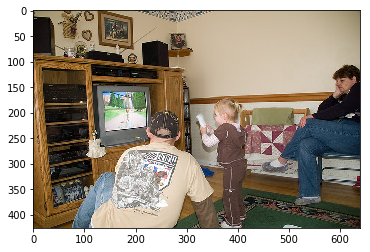

In [16]:
I = skimage.io.imread('./exp-refgoog/coco-dataset/images/train2014/COCO_train2014_000000059593.jpg')
plt.imshow(I)